In [1]:
import numpy as np  
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
import matplotlib

In [3]:
device = torch.device("cuda:2")

In [4]:
class CustomTransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_models, nheads, dropouts,nn_nodes,nn_dropout):
        super(CustomTransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_size, d_models[0])
        
        
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_models[i], 
                nhead=nheads[i], 
                dropout=dropouts[i],
                activation='relu'  
            )
            for i in range(len(d_models))
        ])


        self.intermediate_fc = nn.Linear(d_models[-1], nn_nodes)  
        self.intermediate_activation = nn.ReLU() 
        self.dropout = nn.Dropout(p=nn_dropout) 
        

        self.output_fc = nn.Linear(d_models[0], output_size)
        
        
    def forward(self, x):
        x = self.input_fc(x)
        

        for layer in self.encoder_layers:
            x = layer(x)
        
        x = self.output_fc(x)
        return x


input_size = 1024
output_size = 300
d_models = [1024, 1024, 1024, 1024, 1024, 1024, 1024]
nheads = [4, 4, 4, 4, 4, 4, 4]
nn_nodes = 256
dropouts = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]  
nn_dropout = 0.1


model = CustomTransformerModel(input_size, output_size, d_models, nheads, dropouts,nn_nodes,nn_dropout)


def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)  # 移动到GPU
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)


        model.eval()  
        test_loss = 0.0
        
        with torch.no_grad():
            for features, targets in test_loader:
                features, targets = features.to(device), targets.to(device)  # 移动到GPU
                outputs = model(features)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {avg_test_loss:.8f}")
    
    return train_losses, test_losses



def predict_and_evaluate(loader, model, dataset_type="Test"):
    model.eval()  
    predictions = []
    targets = []
    with torch.no_grad():
        for features, target in loader:
            output = model(features)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    print(f"{dataset_type} RMSE: {rmse}")
    return predictions, targets

In [14]:
data = pd.read_csv('morgan_fingerprints9196.csv')
feature = data.iloc[:, :].values
feature_tensor = torch.tensor(feature, dtype=torch.float32)

In [5]:
batch_size = 16

input_size = 1024 
output_size = 300  
model = CustomTransformerModel(input_size=input_size, output_size=output_size,d_models=d_models,nheads=nheads,dropouts=dropouts,nn_nodes=nn_nodes,nn_dropout=nn_dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [6]:
# 加载模型进行预测
loaded_model = CustomTransformerModel(input_size, output_size, d_models, nheads, dropouts,nn_nodes,nn_dropout)
model_save_path = 'tf_uv.pth'


loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval() 

CustomTransformerModel(
  (input_fc): Linear(in_features=1024, out_features=1024, bias=True)
  (encoder_layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
      )
      (linear1): Linear(in_features=1024, out_features=2048, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (linear2): Linear(in_features=2048, out_features=1024, bias=True)
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.3, inplace=False)
      (dropout2): Dropout(p=0.3, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
      )
      (linear1): Linear(in_features=1024, out_features=2048, bias=True)
      (d

In [15]:
with torch.no_grad():
    predictions = loaded_model(feature_tensor)

In [16]:
predictions_numpy = predictions.cpu().numpy()

In [17]:
np.savetxt('predictions9196.txt', predictions_numpy, delimiter=' ', fmt='%sf')

In [18]:
target_data = pd.read_csv('predictions9196.txt', header=None, delim_whitespace=True)

In [19]:
x = np.arange(0,800,2.66756)

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt  
import matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'

<function matplotlib.pyplot.show(close=None, block=None)>

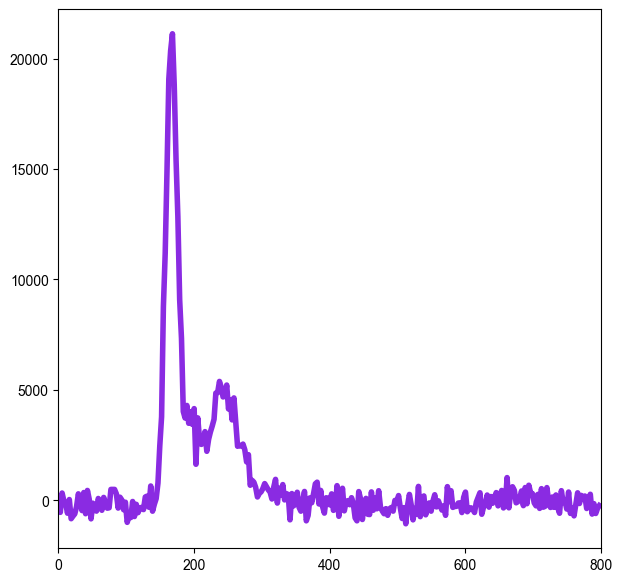

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))

show_num = 0

plt.plot(x, predictions_numpy[show_num, :]*134549.671, c='#8A2BE2', label='Pred',linewidth=4)

plt.xlim(0, 800)



ax.set_xticks(list(range(0, 801, 200)))


#plt.savefig(f'{show_num}.png', bbox_inches='tight', dpi=300)
plt.show